# Solution for the second science case

In [1]:
#########################################
# Author: Eduardo Alberto Duarte Lacerda
# E-mail: dhubax@gmail.com
#########################################

# needed Python imports
# imports for data retrieve
import lsdb
import splusdata
from dask.distributed import Client
# imports for plot and calculation
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy as copy

# auxiliar functions and variables

# https://github.com/splus-collab/splus_filters for S-PLUS filters information
splus_bands = [
    'u', 'J0378', 'J0395', 'J0410', 'J0430', 
    'g', 'J0515', 'r', 'J0660', 'i', 'J0861', 'z',
]
# pivot wavelenght of S-PLUS filters 
splut_bands_pivot_wavelenghts = [
    3533.28, 3773.16, 3940.7, 4094.93, 
    4292.11, 4758.49, 5133.13, 6251.83, 
    6613.88, 7670.61, 8607.25, 8941.48
]

## Read catalogs using LSDB

### Start Dask client

In [2]:
# Start a Dask client for the parallel process used by lsdb
max_cpu = 10
max_mem = '8GB'
client = Client(n_workers=max_cpu, memory_limit=max_mem)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 20,Total memory: 74.51 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36253,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 74.51 GiB
Comm: tcp://127.0.0.1:46485,Total threads: 2
Dashboard: http://127.0.0.1:46151/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:43877,


## S-PLUS Catalogs choice

In [20]:
# search for the full S-PLUS DR4/dual mode catalog
dr4dual_search = splusdata.get_hipscats('dr4/dual')

# Print all catalogs found with the pattern above
print(f'dr4/dual search: {dr4dual_search}')

# select the first catalog found
dr4dual_hipscat, dr4dual_margin_cache_hipscat = dr4dual_search[0]

# Search for the DR4 Star Galaxy Quasar VAC
'''
QSO/star/galaxy classification VAC: 
    https://splus.cloud/documentation/DR4?QSO/star/galaxy_classification
'''
dr4sqg_search = splusdata.get_hipscats('dr4/sqg')
# Print all catalogs found with the pattern above
print(f'dr4/sqg search: {dr4sqg_search}')
# select the first catalog found
dr4sqg_hipscat, dr4sqg_margin_cache_hipscat = dr4sqg_search[0]

# Create the columns list to retrieve only necessaries columns
'''/
We use here choose the magnitudes from 'PStotal' apperture mode.

Read mode about:
     https://splus.cloud/documentation/DR4?Photometry
'''
columns = ['ID', 'Field', 'RA', 'DEC'] 

apperture = 'PStotal'
columns += [f'{b}_{apperture}' for b in splus_bands] 
columns += [f's2n_{b}_{apperture}' for b in splus_bands]
    
# filters 
filters = [('SEX_FLAGS_DET', '==', 0), ('CLASS_STAR', '>=', 0.9)]

dr4/dual search: [['https://splus.cloud/HIPS/catalogs/dr4/dual/', 'https://splus.cloud/HIPS/catalogs/dr4/dual_2arcsec/']]
dr4/sqg search: [['https://splus.cloud/HIPS/catalogs/dr4_vacs/sqg/sqg/', 'https://splus.cloud/HIPS/catalogs/dr4_vacs/sqg/sqg_2arcsec/']]


### Read DR4/dual and QSO/star/galaxy catalogs

In [21]:
# Read more about the need of the margin cache server at:
#      https://lsdb.readthedocs.io/en/stable/tutorials/margins.html    
dr4dual_margin = lsdb.read_hipscat(dr4dual_margin_cache_hipscat)
dr4sqg_margin = lsdb.read_hipscat(dr4sqg_margin_cache_hipscat)

# Read DR4 dual HiPSCAT
dr4dual = lsdb.read_hipscat(
    dr4dual_hipscat,
    margin_cache=dr4dual_margin,
    # Read more about the available columns at:
    #      https://splus.cloud/documentation/DR4?Schemas,_tables_and_columns
    columns=columns,
    #filters=filters,
)

# Read DR4 QSO/star/galaxy classification VAC HiPSCAT
# Here we filter only objects where the galaxy probability
# is greater than 80%
dr4sqg = lsdb.read_hipscat(
    dr4sqg_hipscat,
    margin_cache=dr4sqg_margin,
    filters=[('PROB_STAR', '>', 0.9)],
)

/home/lacerda/.pyenv/versions/dev/lib/python3.12/site-packages/hipscat/io/file_io/file_io.py:320: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(


In [22]:
# GAIA DR3 HiPSCat
gaia = lsdb.read_hipscat(
    'https://data.lsdb.io/unstable/gaia_dr3/gaia/',
    margin_cache='https://data.lsdb.io/unstable/gaia_dr3/gaia_10arcs/',
    columns=[
        'source_id',
        'ra',
        'dec',
        'parallax',
        'parallax_error',
    ],
)

## Perform the crossmatch

In [23]:
# Do the crossmatch of both catalogs. 
identity_radius = 1  # arcsec
dr4dualsqg_crosmatch = dr4sqg.crossmatch(dr4dual, suffixes=['_dual', '_sqg'], radius_arcsec=identity_radius)

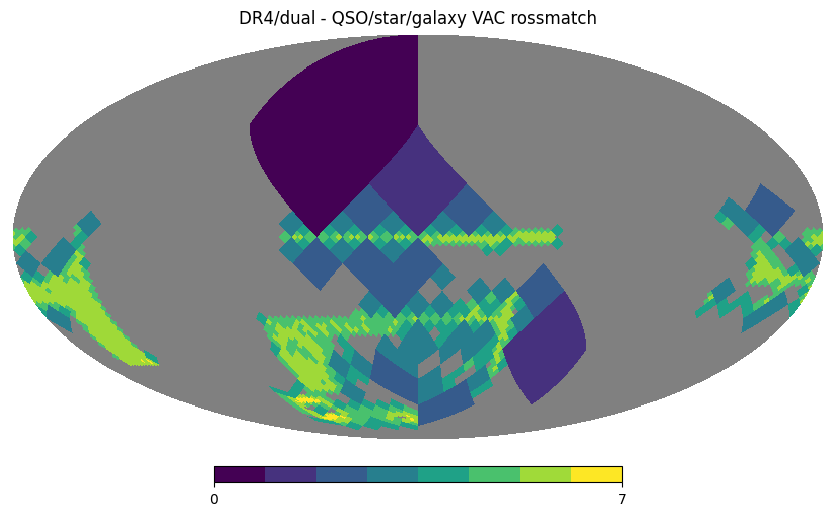

In [24]:
# You can use plot_pixels() to observe the catalog’s sky coverage map and 
# obtain information about its HEALPix distribution.
dr4dualsqg_crosmatch.plot_pixels('DR4/dual - QSO/star/galaxy VAC rossmatch')

In [25]:
dr4dualsqggaia_crosmatch = dr4dualsqg_crosmatch.crossmatch(gaia, suffixes=['_dualsqg', '_gaia'], radius_arcsec=1)

## Search for objects using the crossmatch result table

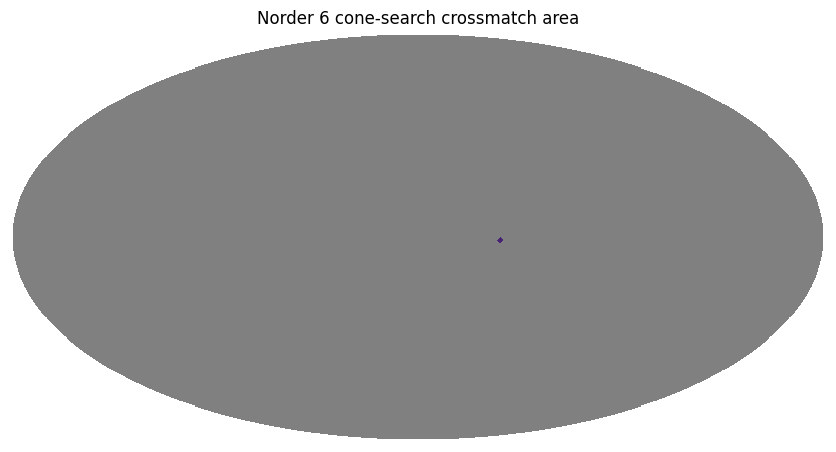

In [26]:
# Let's get the resultant table:
cone_center_coord = (323.36249, -0.82333) # RA and DEC in degrees
cone_radius = 30*60 # arcsec
objects_table_crossmatch = dr4dualsqggaia_crosmatch.cone_search(ra=cone_center_coord[0], dec=cone_center_coord[1], radius_arcsec=cone_radius)
#objects_table_crossmatch = dr4dualsqg_crosmatch.box_search([323, 324], [-1.3, -0.5])
objects_table_crossmatch.plot_pixels('cone-search crossmatch area')

In [27]:
objects_table = objects_table_crossmatch.compute()

In [28]:
objects_table.columns

Index(['ID_dual_dualsqg', 'RA_dual_dualsqg', 'DEC_dual_dualsqg',
       'CLASS_dual_dualsqg', 'model_flag_dual_dualsqg',
       'PROB_QSO_dual_dualsqg', 'PROB_STAR_dual_dualsqg',
       'PROB_GAL_dual_dualsqg', 'Norder_dual_dualsqg', 'Dir_dual_dualsqg',
       'Npix_dual_dualsqg', 'ID_sqg_dualsqg', 'Field_sqg_dualsqg',
       'RA_sqg_dualsqg', 'DEC_sqg_dualsqg', 'u_PStotal_sqg_dualsqg',
       'J0378_PStotal_sqg_dualsqg', 'J0395_PStotal_sqg_dualsqg',
       'J0410_PStotal_sqg_dualsqg', 'J0430_PStotal_sqg_dualsqg',
       'g_PStotal_sqg_dualsqg', 'J0515_PStotal_sqg_dualsqg',
       'r_PStotal_sqg_dualsqg', 'J0660_PStotal_sqg_dualsqg',
       'i_PStotal_sqg_dualsqg', 'J0861_PStotal_sqg_dualsqg',
       'z_PStotal_sqg_dualsqg', 's2n_u_PStotal_sqg_dualsqg',
       's2n_J0378_PStotal_sqg_dualsqg', 's2n_J0395_PStotal_sqg_dualsqg',
       's2n_J0410_PStotal_sqg_dualsqg', 's2n_J0430_PStotal_sqg_dualsqg',
       's2n_g_PStotal_sqg_dualsqg', 's2n_J0515_PStotal_sqg_dualsqg',
       's2n_r_PStotal

<hr>

## Create plots

###  Spatial distribution plot

Text(0.5, 0, 'DEC')

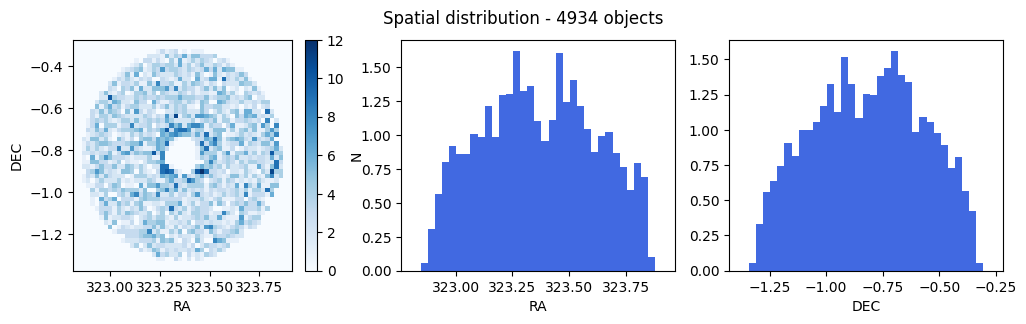

In [29]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(12, 3)
N = len(objects_table)
f.suptitle(f'Spatial distribution - {N} objects')
ra = objects_table['RA_dual_dualsqg']
dec = objects_table['DEC_dual_dualsqg']
x = cone_radius/3600
ra_range = cone_center_coord[0]+np.array([-1.1*x, 1.1*x])
dec_range = cone_center_coord[1]+np.array([-1.1*x, 1.1*x])
_, _, _, im1 = ax1.hist2d(ra, dec, bins=50, range=[ra_range, dec_range], cmap='Blues')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
cax = plt.colorbar(im1, ax=ax1)
cax.ax.set_ylabel('N')
ax2.hist(ra, bins=35, range=ra_range, density=True, color='royalblue', histtype='stepfilled')
ax2.set_xlabel('RA')
ax3.hist(dec, bins=35, range=dec_range, density=True, color='royalblue', histtype='stepfilled')
ax3.set_xlabel('DEC')

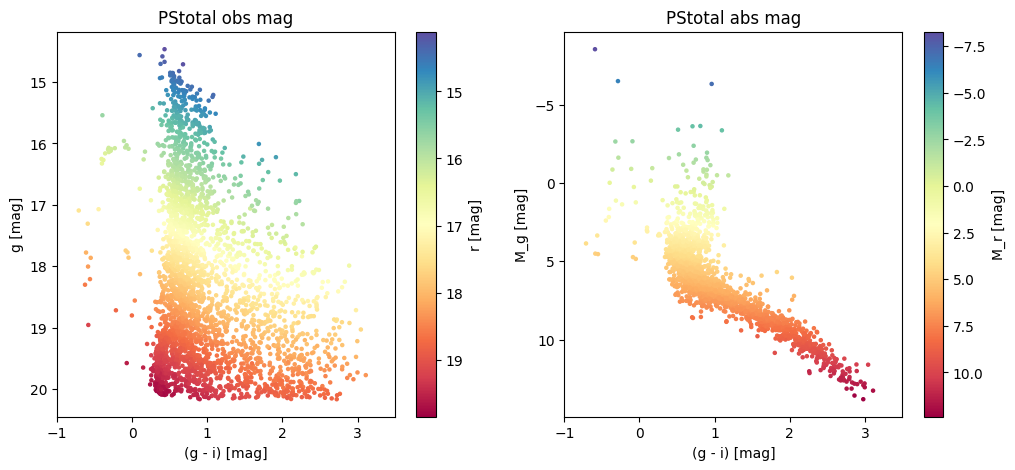

In [45]:
mask = (objects_table[f's2n_g_{apperture}_sqg_dualsqg'] > 30)
mask &= (objects_table[f's2n_g_{apperture}_sqg_dualsqg'] < 1000)
mask &= (objects_table[f's2n_i_{apperture}_sqg_dualsqg'] > 30)
mask &= (objects_table[f's2n_i_{apperture}_sqg_dualsqg'] < 1000)

for band in ['r', 'g', 'i']:
    mask = np.bitwise_and(mask, objects_table[f'{band}_{apperture}_sqg_dualsqg'] > 14)
    mask = np.bitwise_and(mask, objects_table[f'{band}_{apperture}_sqg_dualsqg'] < 21)

x = objects_table[f'g_{apperture}_sqg_dualsqg'] - objects_table[f'i_{apperture}_sqg_dualsqg']
y = objects_table[f'g_{apperture}_sqg_dualsqg']
z = objects_table[f'r_{apperture}_sqg_dualsqg']

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(12, 5)
im = ax1.scatter(x[mask], y[mask], c=z[mask], s=5, cmap='Spectral_r')
ax1.set_title(f'{apperture} obs mag')
cax = plt.colorbar(im, ax=ax1)
cax.ax.set_ylabel('r [mag]')
cax.ax.invert_yaxis()
ax1.set_xlabel(f'(g - i) [mag]')
ax1.set_ylabel(f'g [mag]')
ax1.set_xlim(-1, 3.5)
ax1.invert_yaxis()

par = objects_table['parallax_gaia']
epar = objects_table['parallax_error_gaia']
mabs_corr = -5*np.log10(1/(par*0.001)) + 5
mask &= (epar < 0.2)
y = copy(y) + mabs_corr
z = copy(z) + mabs_corr

im = ax2.scatter(x[mask], y[mask], c=z[mask], s=5, cmap='Spectral_r')
ax2.set_title(f'{apperture} abs mag')
cax = plt.colorbar(im, ax=ax2)
cax.ax.set_ylabel('M_r [mag]')
cax.ax.invert_yaxis()
ax2.set_xlabel(f'(g - i) [mag]')
ax2.set_ylabel(f'M_g [mag]')
ax2.set_xlim(-1, 3.5)
ax2.invert_yaxis()